### Relevant links

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%load_ext autotime

In [2]:
from scripts.imports import * #XGboost should be loaded in the beginning to avoid errors
import scripts.kaggle_data as kd

from toolbox import *
from scripts.future_sales_prediction_custom import *

time: 5.03 s


In [3]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

time: 1.31 ms


### Getting data

In [ ]:
current_path = os.getcwd()
data_dir_path = os.path.join(current_path,"data")

if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

print(data_dir_path) #Never print

In [ ]:
kd.download_data('competitive-data-science-predict-future-sales',current_path)

In [718]:
#Listify files to download
all_data_files = os.listdir('data/') #Getting all files in data folder in a list
all_data_files = [x for x in all_data_files if x.endswith('.csv')] #Removing .ipynb files
all_data_files = [remove_from_right(x,4) for x in all_data_files] #Removing .csvs
all_data_files

['shops',
 'items',
 'item_categories',
 'sales_train',
 'sample_submission',
 'test']

time: 130 ms


In [719]:
for i in all_data_files:
    print(i + "=" + f"kd.read_data('data/','csv','{i}')")
    print("")
    exec(i + "=" + f"kd.read_data('data/','csv','{i}')")
    exec(f"shape = {i}.shape")
    print(f"Shape of {i}: ", shape)
    exec(f"data_types = {i}.dtypes")
    print("")
    print(f"Data types in {i}: \n \n ", data_types)
    print("---------------------")

shops=kd.read_data('data/','csv','shops')

Shape of shops:  (60, 2)

Data types in shops: 
 
  shop_name    object
shop_id       int64
dtype: object
---------------------
items=kd.read_data('data/','csv','items')

Shape of items:  (22170, 3)

Data types in items: 
 
  item_name           object
item_id              int64
item_category_id     int64
dtype: object
---------------------
item_categories=kd.read_data('data/','csv','item_categories')

Shape of item_categories:  (84, 2)

Data types in item_categories: 
 
  item_category_name    object
item_category_id       int64
dtype: object
---------------------
sales_train=kd.read_data('data/','csv','sales_train')

Shape of sales_train:  (2935849, 6)

Data types in sales_train: 
 
  date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
---------------------
sample_submission=kd.read_data('data/','csv','sample_submission')

Sh

In [720]:
test_for_submission = test.copy()

time: 2.23 ms


### Testing data

#### Structural checks

In [ ]:
#Unique data values
#sales_train >> \
#select(X.date,X.date_block_num) >> \
#distinct(X.date,X.date_block_num) >> \
#arrange(X.date_block_num, ascending = True) 

#Finding
#We have daily sales data as well

In [ ]:
#Check for missing value in train data
#for k in sales_train.columns:
    #display_all(sales_train >> summarise_each([null_percent],k))

#### See headers of all data

In [ ]:
sales_train >> head

In [ ]:
shops >> head

In [ ]:
items >> head

In [ ]:
item_categories >> head

In [ ]:
test >> head

### Feature engineering

#### Create features

In [721]:
# Add dates to training data
raw_data = add_datepart(inp_df = sales_train, custom_date_format = '%d.%m.%Y',field_name = 'date', drop = False)

time: 4.29 s


In [722]:
#Negative price
raw_data.loc[raw_data.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_original,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
484683,2013-05-15,4,32,2973,-1.0,1.0,15.05.2013,2013,5,20,15,2,135,False,False,False,False,False,False,1368576000


time: 336 ms


In [723]:
#Replace with median
median = raw_data[(raw_data.shop_id==32)&(raw_data.item_id==2973)&(raw_data.date_block_num==4)&(raw_data.item_price>0)].item_price.median()
raw_data.loc[raw_data.item_price<0, 'item_price'] = median
print("The median is: ", median)

The median is:  1874.0
time: 217 ms


In [724]:
#Outliers
raw_data = raw_data[raw_data.item_price<100000]
raw_data = raw_data[raw_data.item_cnt_day<1001]

time: 596 ms


In [725]:
#Several shops are duplicates of each other (according to its name). Fix train and test set.

# Якутск Орджоникидзе, 56
raw_data.loc[raw_data.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
test_for_submission.loc[test_for_submission.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
raw_data.loc[raw_data.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
test_for_submission.loc[test_for_submission.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
raw_data.loc[raw_data.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
test_for_submission.loc[test_for_submission.shop_id == 10, 'shop_id'] = 11

time: 429 ms


In [726]:
#Modifying dimension tables
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
# if subtype is nan then type
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

time: 21.2 ms


In [727]:
#Convert item_id and shop_id as strings
#Do not replace negative values of sales with 0 
#Since we want to compute total sales in a month
raw_data = raw_data >> mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str))

time: 5.22 s


In [728]:
#Get avg price of each item by a rolling window
monthly_item_price = dd_summarise(raw_data,['item_id','date_block_num'],{'item_price': ['mean','max','min']})

#Sort for proper rolling calculations
monthly_item_price = monthly_item_price >> arrange(X.item_id,X.date_block_num)

#Rolling average
monthly_item_price['item_price_rolling'] =monthly_item_price.groupby(['item_id'])['item_price_mean'].rolling(window=36,min_periods = 1).mean().reset_index(0,drop=True)

#last month min
monthly_item_price['item_price_lm_min'] = monthly_item_price.groupby(['item_id'])['item_price_min'].shift(1)

#last month max
monthly_item_price['item_price_lm_max'] = monthly_item_price.groupby(['item_id'])['item_price_max'].shift(1)

#Replace NULLs
monthly_item_price.fillna(-999,inplace = True)

#Final table
monthly_item_price = monthly_item_price[['item_id',
                                         'date_block_num',
                                         'item_price_mean',
                                         'item_price_rolling',
                                         'item_price_lm_min',
                                         'item_price_lm_max']]

time: 19.2 s


In [729]:
#Test
test = test >> mutate(item_id = X.item_id.astype(str), 
                           shop_id = X.shop_id.astype(str), 
                           date_block_num = 34) >> drop(X.ID)

time: 420 ms


In [730]:
#Get distance last sold and first sold distance in number of months for item
item_month = dd_summarise(raw_data,['item_id','date_block_num'],{'item_cnt_day': ['sum']}) >> \
mask(X.item_cnt_day_sum > 0) >> drop(X.item_cnt_day_sum)

#Add all test cases
test_item_month = test >> select(X.item_id,X.date_block_num) >> distinct(X.item_id,X.date_block_num)
item_month = pd.concat([item_month,test_item_month], sort = True)

#Sort for proper rolling calculations
item_month = item_month >> arrange(X.item_id,X.date_block_num)

#Shift
item_month['shifted'] =item_month.groupby(['item_id'])['date_block_num'].shift(1)

#Rolling min
item_month['first_month'] =item_month.groupby(['item_id'])['shifted'].rolling(window=36,min_periods = 1).min().reset_index(0,drop=True)

#Rolling max
item_month['last_month'] =item_month.groupby(['item_id'])['shifted'].rolling(window=36,min_periods = 1).max().reset_index(0,drop=True)

#Compute distance
item_month = item_month >> \
mutate(item_dist_from_first_month = if_else(X.first_month.isnull(),0,X.date_block_num - X.first_month),
       item_dist_from_last_month = if_else(X.last_month.isnull(),0,X.date_block_num - X.last_month))

item_month = item_month[['item_id','date_block_num','item_dist_from_first_month','item_dist_from_last_month']]

time: 34.3 s


In [731]:
#Compute monthly metrics
#number of purchases
#Translate everything daily to monthly

metric_dictionary = {'item_cnt_day': ['sum']}

raw_data_month = dd_summarise(raw_data,['item_id','shop_id','date_block_num'],metric_dictionary)

time: 4.43 s


In [732]:
#Cap sales value from 0 to 20
raw_data_month = raw_data_month >> \
mutate(item_cnt_day_sum = if_else(X.item_cnt_day_sum > 20, 20, X.item_cnt_day_sum)) >> \
mutate(item_cnt_day_sum = if_else(X.item_cnt_day_sum < 0, 0, X.item_cnt_day_sum))

time: 1.57 s


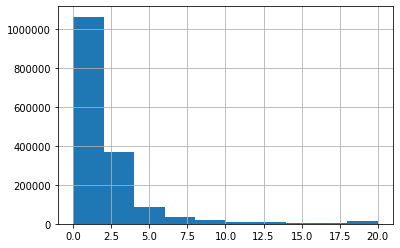

time: 367 ms


In [733]:
raw_data_month.item_cnt_day_sum.hist()

In [734]:
#Train and valid
date_block_item = raw_data >> select(X.date_block_num, X.item_id) >> distinct(X.date_block_num, X.item_id)
date_block_shop = raw_data >> select(X.date_block_num, X.shop_id) >> distinct(X.date_block_num, X.shop_id)

sparse = date_block_item >> inner_join(date_block_shop, by = ['date_block_num']) 

sparse = pd.concat([sparse, test], sort=True) >> arrange(X.item_id,X.shop_id,X.date_block_num)

sparse = sparse >> left_join(raw_data_month, by = ['item_id','shop_id','date_block_num'])

sparse.fillna(0,inplace = True) #all left join col's NULLs can be replaced with 0s

print("Shape of sparse data: ", sparse.shape )

Shape of sparse data:  (11128004, 4)
time: 25.8 s


In [735]:
#Add rolling price 
sparse = pd.merge(sparse, monthly_item_price, on=['item_id','date_block_num'], how='left')

# Compute difference
sparse = sparse >> \
mutate(price_diff_w_rolling_avg = (X.item_price_rolling - X.item_price_mean)/X.item_price_mean,
      price_diff_w_last_month_min = if_else(X.item_price_lm_min == -999,
                            0,
                            (X.item_price_lm_min - X.item_price_mean)/X.item_price_mean  ),
      price_diff_w_last_month_max = if_else(X.item_price_lm_max == -999,
                            0,
                            (X.item_price_lm_max - X.item_price_mean)/X.item_price_mean  ))

sparse.fillna(0,inplace = True) #all left join col's NULLs can be replaced with 0s

time: 18.2 s


In [736]:
#Add distance from last activity metrics
sparse = sparse >> left_join(item_month, by = ['item_id','date_block_num'])

time: 4.17 s


In [737]:
#Lag variables for all data sets
metric_list = ['item_cnt_day_sum',
               'price_diff_w_rolling_avg']

sparse = apply_lag(sparse,['item_id','shop_id'],'date_block_num', metric_list,[1,2,3])

#Coalesce
sparse["delta_price"] = sparse['price_diff_w_rolling_avg_lag_1'].combine_first(sparse['price_diff_w_rolling_avg_lag_2']).combine_first(sparse['price_diff_w_rolling_avg_lag_3'])

#Drop price lags
sparse.drop(['price_diff_w_rolling_avg_lag_1',
             'price_diff_w_rolling_avg_lag_2',
             'price_diff_w_rolling_avg_lag_3'], axis=1,inplace = True)

#Replace sales lag NAs with 0s and also some remaining delta price fields
sparse.fillna(0,inplace = True)

#Remove months < 12 since we are using 12 lags
sparse = sparse[sparse.date_block_num > 11]

#Print for checking
print('Shape before NaN removal: ',sparse.shape )

lag: 1 done
lag: 2 done
lag: 3 done
Metric: item_cnt_day_sum done
lag: 1 done
lag: 2 done
lag: 3 done
Metric: price_diff_w_rolling_avg done
Shape before NaN removal:  (6639294, 17)
time: 38.8 s


In [738]:
#Get date features for all date block num
sparse['month'] = sparse['date_block_num'] % 12

time: 136 ms


In [739]:
#Add number of days in a month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
sparse['days'] = sparse['month'].map(days).astype(np.int8)

time: 288 ms


In [740]:
#Item category size 
sparse = item_category_size(sparse,items)

time: 11.2 s


In [741]:
#Add other item shop cartegory level data
shops = shops >> mutate(shop_id = X.shop_id.astype(str))

sparse = pd.merge(sparse, shops, on=['shop_id'], how='left')

sparse = pd.merge(sparse, item_categories, on=['item_category_id'], how='left')


sparse['item_category_id'] = sparse['item_category_id'].astype(np.int8)
sparse['city_code'] = sparse['city_code'].astype(np.int8)
sparse['type_code'] = sparse['type_code'].astype(np.int8)
sparse['subtype_code'] = sparse['subtype_code'].astype(np.int8)

time: 4.91 s


In [742]:
#Parameters for next set of features

metric_list_sales_5 = ['item_cnt_day_sum_lag_1',
                     'item_cnt_day_sum_lag_2',
                     'item_cnt_day_sum_lag_3']

metric_list_sales_1 = ['item_cnt_day_sum_lag_1']



date = ['date_block_num']
item_date = ['item_id','date_block_num']
shop_date = ['shop_id','date_block_num']
cat_date = ['item_category_id','date_block_num']
cat_shop_date = ['item_category_id','shop_id','date_block_num']
date_city = ['city_code','date_block_num']
date_item_city = ['city_code','item_id','date_block_num']

time: 1.61 ms


In [743]:
#Create new features from the lag features
sparse = apply_ts(sparse,item_date,metric_list_sales_5,None,'mean','item_date','m', False )
sparse = apply_ts(sparse,shop_date,metric_list_sales_5,None,'mean','shop_date','m', False )

sparse = apply_ts(sparse,date,metric_list_sales_1,None,'mean','date','m' , False)
sparse = apply_ts(sparse,cat_date,metric_list_sales_1,None,'mean','cat_date','m', False )
sparse = apply_ts(sparse,cat_shop_date,metric_list_sales_1,None,'mean','cat_shop_date','m' , False)
sparse = apply_ts(sparse,date_city,metric_list_sales_1,None,'mean','date_city','m', False )
sparse = apply_ts(sparse,date_item_city,metric_list_sales_1,None,'mean','date_item_city','m', False )

time: 1min 25s


In [744]:
#Convert item_id and shop_id back to numeric format
sparse['shop_id'] = sparse['shop_id'].astype(np.int32)
sparse['item_id'] = sparse['item_id'].astype(np.int32)

time: 1.67 s


In [745]:
#Now generate train, valid and test DFs
train = sparse >> mask(X.date_block_num < 33)
valid = sparse >> mask(X.date_block_num == 33)
test_w_features = sparse >> mask(X.date_block_num == 34)

# sparse.to_pickle('data/sparse.pkl')

del sparse

time: 6.8 s


In [746]:
# sparse = pd.read_pickle('data/sparse.pkl')

time: 777 µs


### EDA

#### Check distribution

In [ ]:
check = dd_summarise(raw_data,['date_block_num','item_id','shop_id'],'item_cnt_day','sum')

In [ ]:
check[check.item_cnt_day > 20].shape[0]/check.shape[0]

In [ ]:
sns.distplot(check.item_cnt_day[check.item_cnt_day>0])

### Modelling

#### Xgboost

In [747]:
##data preparation
ind_columns = train.columns.to_list()

dep_coloumns = ["item_cnt_day_sum"]

cols_to_remove = ["item_price_mean",
                  "item_price_rolling",
                  'item_price_lm_min',
                  'item_price_lm_max',
                  'price_diff_w_rolling_avg',
                  'price_diff_w_last_month_min',
                  'price_diff_w_last_month_max']

ind_columns = remove_elements(ind_columns, dep_coloumns)
ind_columns = remove_elements(ind_columns, cols_to_remove)

x_train = train[ind_columns]
y_train = train[dep_coloumns]

x_test = test_w_features[ind_columns]

x_valid = valid[ind_columns]
y_valid = valid[dep_coloumns]

print("Shape of training data: ", x_train.shape)
print("Shape of validation data: ", x_valid.shape)
print("Shape of test data: ", x_test.shape)

xg_train = xgb.DMatrix(x_train, label = y_train)
xg_test = xgb.DMatrix(x_test)
xg_valid = xgb.DMatrix(x_valid, label = y_valid)

Shape of training data:  (6186922, 27)
Shape of validation data:  (238172, 27)
Shape of test data:  (214200, 27)
time: 5.16 s


In [ ]:
#Model
param = {'max_depth':10,
         'min_child_weight':100,
         'objective':'reg:squarederror',
         'eval_metric': 'rmse' ,
         'colsample_bytree': 0.8,
         'subsample':0.8, 
         'eta':0.1}

watchlist  = [(xg_train, 'train'),(xg_valid, 'valid')]
num_round = 1000

xgm = xgb.train(param, xg_train, num_round, evals = watchlist, early_stopping_rounds=10)

[00:03:59] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.14904	valid-rmse:1.11465
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.09929	valid-rmse:1.07404
[2]	train-rmse:1.05662	valid-rmse:1.03966
[3]	train-rmse:1.02061	valid-rmse:1.01322
[4]	train-rmse:0.989976	valid-rmse:0.989724


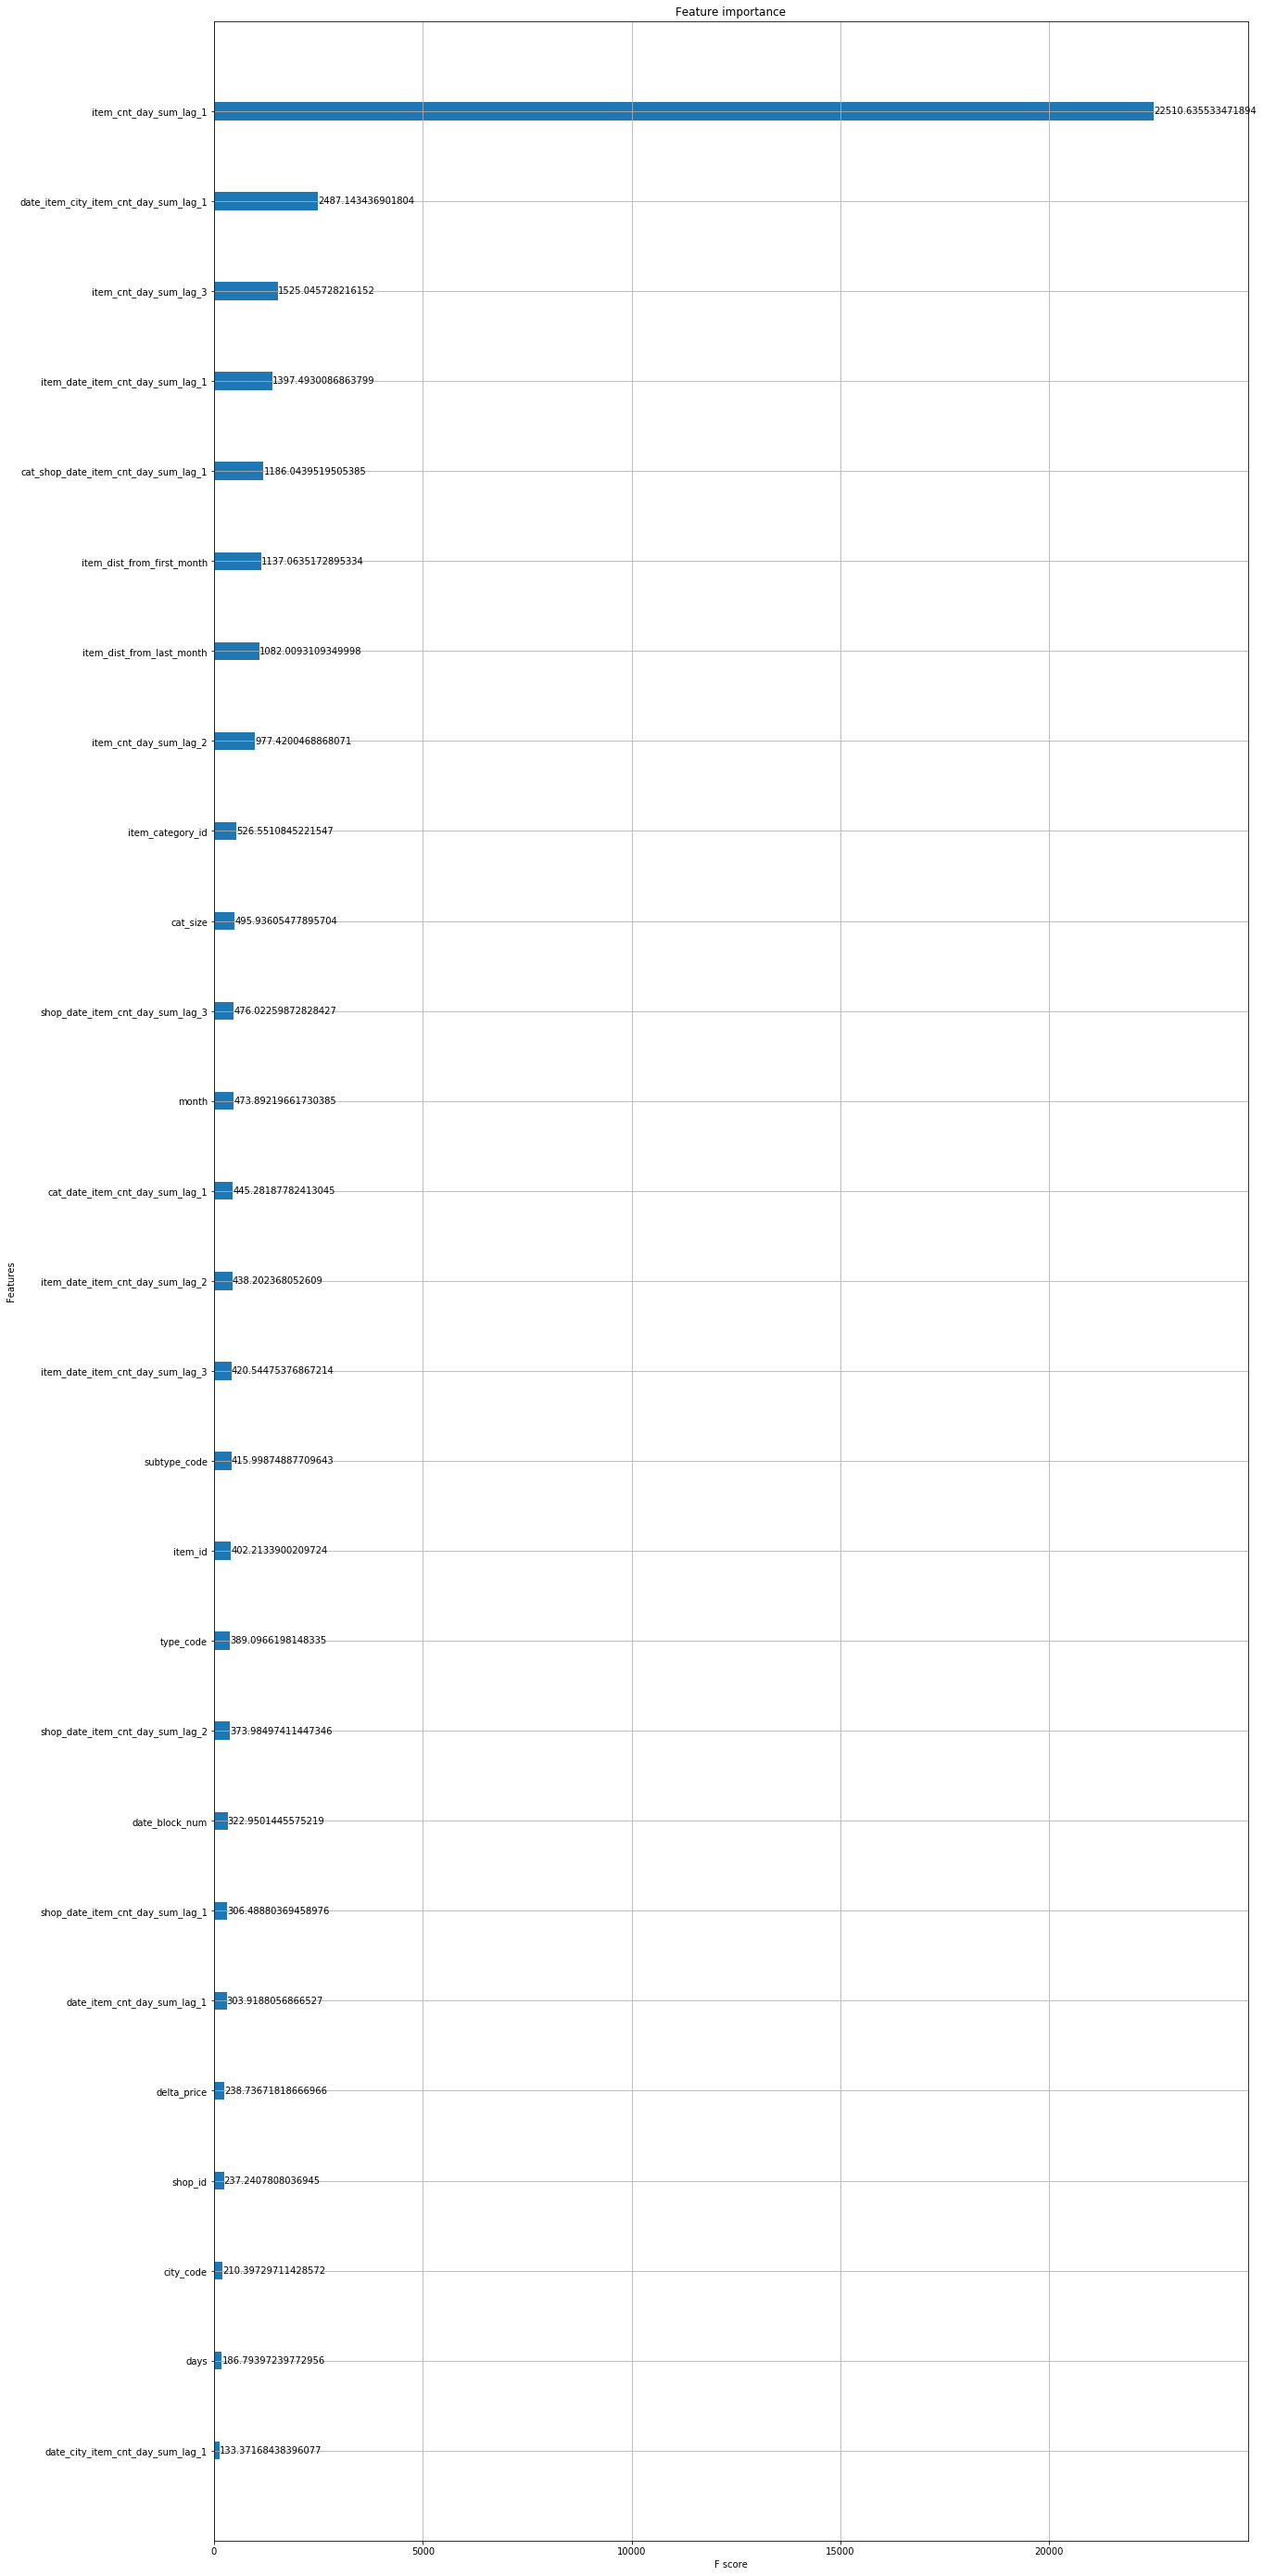

time: 2.19 s


In [770]:
my_plot_importance(xgm,(20,50),importance_type='gain')

In [771]:
#RMSE in valid data
rmse(xgm.predict(xg_valid, ntree_limit=xgm.best_ntree_limit),y_valid.values.ravel())

0.9005104532080151

time: 88.9 ms


In [772]:
#RMSE in train data
rmse(xgm.predict(xg_train, ntree_limit=xgm.best_ntree_limit),y_train.values.ravel())

0.8185260721806151

time: 2.49 s


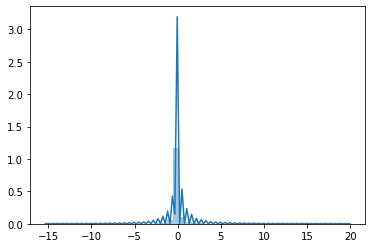

time: 564 ms


In [773]:
valid_predictions = xgm.predict(xg_valid, ntree_limit=xgm.best_ntree_limit)
valid_predictions = valid >> mutate(item_cnt_day_predicted = valid_predictions) >> \
mutate(errors = (X.item_cnt_day_sum - X.item_cnt_day_predicted))

vp = valid_predictions

sns.distplot(vp.item_cnt_day_sum - vp.item_cnt_day_predicted)

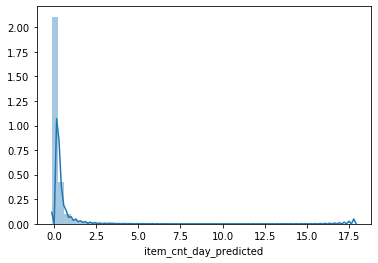

time: 446 ms


In [774]:
#Need to clip predictions
sns.distplot(vp.item_cnt_day_predicted)

### Submission

In [775]:
#test_predictions = xgm.predict(xg_test, ntree_limit=xgm.best_ntree_limit)
test_predictions = xgm.predict(xg_test)
test_predictions.shape

(214200,)

time: 141 ms


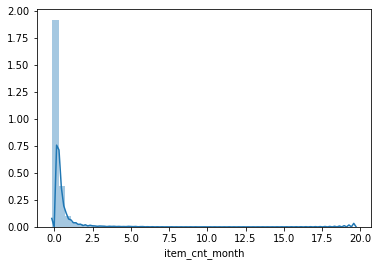

time: 445 ms


In [776]:
test_submission = test_w_features >> mutate(item_cnt_month = test_predictions) >> \
select(X.item_id,X.shop_id,X.date_block_num,X.item_cnt_month)
sns.distplot(test_submission.item_cnt_month)

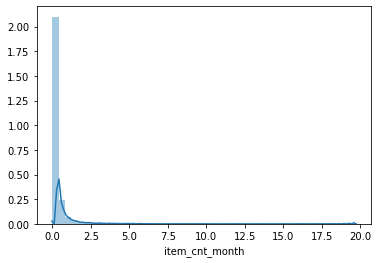

time: 654 ms


In [777]:
test_submission = test_submission >> \
mutate(item_cnt_month = if_else(X.item_cnt_month > 20, 20, X.item_cnt_month)) >> \
mutate(item_cnt_month = if_else(X.item_cnt_month < 0, 0, X.item_cnt_month))
sns.distplot(test_submission.item_cnt_month)

In [778]:
test_for_submission_m = test_for_submission >> left_join(test_submission, by = ['item_id','shop_id']) >> \
select(X.ID,X.item_cnt_month)

time: 85 ms


In [779]:
test_for_submission_m.to_csv('submission__xgb_v10.csv', index=False)

time: 1.9 s


### QA